In [72]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [ ]:
# To notify when cell is complete (comment out first line). Add %%notify to the first line of a cell to get notified
# !pip uninstall jupyternotify -y
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [3]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)
massive.reset_index(drop=True, inplace=True)

### Pre-processing

In [4]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta
0,Robin Hood,43.0,Dawn Taylor,Cinematical,It's a little like making a Johnny Appleseed m...,NEGATIVE,-15.0


In [21]:
# Binning delta column into 5 categories for Logistic regression
bins = [-99, -26, -11, 10, 25, 99]
labels = [0, 1, 2, 3, 4]
massive['delta_category'] = pd.cut(massive['delta'], bins=bins, labels=labels)

In [25]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
delta_category    0
dtype: int64

In [26]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Resetting index after dropping dupe's
massive.reset_index(drop=True, inplace=True)
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title              7243
tomatoMeter       14885
criticName        11924
publicatioName    13487
reviewText            0
scoreSentiment    14984
delta             14865
delta_category    14981
dtype: int64

## BERT Vectorizer

In [27]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
%%notify
# Text preprocessing function
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
massive['embeddings'] = massive.reviewText.map(lambda x: get_embedding(x))
massive.head()

C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
0,Robin Hood,43.0,Dawn Taylor,Cinematical,It's a little like making a Johnny Appleseed m...,NEGATIVE,-15.0,1,"[-0.15825821, 0.23516954, 0.037855532, 0.03154..."
1,Safe House,53.0,Jeff Beck,Examiner.com,"[""Safe House""] becomes a prime example of why ...",NEGATIVE,-10.0,2,"[0.05020408, 0.4886594, -0.008877138, -0.08937..."
2,Queen & Slim,83.0,Tim Cogshell,FilmWeek (KPCC - NPR Los Angeles),Very entertaining in a number of ways. Thrilli...,POSITIVE,-9.0,2,"[-0.44251788, 0.51001436, 0.23970549, -0.13053..."
3,Lost in Beijing,52.0,Jack Mathews,New York Daily News,When a rapist (Tony Leung) is the second-most ...,NEGATIVE,-7.0,2,"[-0.3622491, 0.3521909, 0.016124029, -0.053949..."
4,Drive My Car,97.0,Danny Leigh,Financial Times,Director Ryusuke Hamaguchi makes it easy to st...,POSITIVE,19.0,3,"[-0.0665307, 0.29908082, 0.11836646, 0.0174265..."


<IPython.core.display.Javascript object>

In [29]:
# Converting embeddings column to numpy array
vectors = np.array(massive.embeddings.tolist(), dtype='float')
vectors[:10]

array([[-0.15825821,  0.23516954,  0.03785553, ..., -0.12963331,
         0.41126922,  0.15984839],
       [ 0.05020408,  0.48865941, -0.00887714, ..., -0.23357064,
         0.26069748, -0.09811916],
       [-0.44251788,  0.51001436,  0.23970549, ..., -0.27318379,
         0.36491105, -0.16944979],
       ...,
       [-0.01660984,  0.24159062, -0.22176614, ..., -0.10410111,
         0.32589257,  0.13528441],
       [-0.03979871,  0.32638577, -0.09368794, ..., -0.11670193,
         0.2325905 , -0.22093023],
       [-0.63761503,  0.22267888, -0.20360245, ..., -0.05600252,
         0.01459969, -0.08805501]])

In [30]:
# Flattening numpy array and creating dataframe with it
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,-0.158258,0.235170,0.037856,0.031540,0.306124,0.170648,-0.103593,0.573045,-0.020362,-0.005003,...,-0.002762,-0.303216,0.097986,0.199727,0.036453,-0.065421,-0.037108,-0.129633,0.411269,0.159848
1,0.050204,0.488659,-0.008877,-0.089375,0.322270,0.192425,0.104532,0.458823,-0.101944,-0.106463,...,-0.242976,-0.178034,0.097337,-0.016775,-0.038906,-0.024188,0.170549,-0.233571,0.260697,-0.098119
2,-0.442518,0.510014,0.239705,-0.130538,0.411279,-0.033510,0.003244,0.558496,-0.100562,-0.543049,...,0.159986,-0.209504,0.237903,-0.176496,-0.213456,-0.256748,0.115339,-0.273184,0.364911,-0.169450


In [31]:
# Dropping review text now it is vectorized, and dropping embeddings now that it is flattened
massive = massive.drop(columns=['reviewText', 'embeddings', 'delta'])

In [32]:
massive.isnull().sum().head(9)

title             0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta_category    0
dtype: int64

### Encoding categorical columns

In [33]:
# Renaming the least-appearing critics as Other to later be encoded as the same critic
counts = massive.criticName.value_counts()
threshold = massive.criticName.isin(counts.index[counts<16])
massive.loc[threshold, 'criticName'] = 'Other'
massive['criticName'].value_counts()

Other                            8737
Dennis Schwartz                   103
Frederic and Mary Ann Brussat      84
Roger Ebert                        82
Roger Moore                        81
                                 ... 
Shawn Levy                         16
Richard Brody                      16
Dennis Harvey                      16
Gary Wolcott                       16
Alonso Duralde                     16
Name: criticName, Length: 228, dtype: int64

In [34]:
# Repeat for publications
counts = massive.publicatioName.value_counts()
threshold = massive.publicatioName.isin(counts.index[counts<12])
massive.loc[threshold, 'publicatioName'] = 'Other'
massive['publicatioName'].value_counts()

Other                           4117
New York Times                   193
Variety                          183
Los Angeles Times                166
Time Out                         143
                                ... 
SF Weekly                         12
Patrick Nabarro                   12
Your Movies (cleveland.com)       12
Film Racket                       12
The New York Review of Books      12
Name: publicatioName, Length: 334, dtype: int64

In [35]:
# List of columns to dummy
categorical_cols = ['title', 'criticName', 'publicatioName', 'scoreSentiment'] 
# Get dummies on categorical columns
massive = pd.get_dummies(massive, columns = categorical_cols)

### Final pre-processing, splitting, scaling, PCA

In [36]:
# Merging massive df with vectorized df
combined = pd.concat([massive, v_df], axis=1)
combined.head(1)

,tomatoMeter,delta_category,"title_""Sr.""",title_$9.99,title_'71,title_(500) Days of Summer,title_(Untitled),title_... And They Lived Happily Ever After,title_...And Justice for All,title_10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
0,43.0,1,0,0,0,0,0,0,0,0,...,-0.002762,-0.303216,0.097986,0.199727,0.036453,-0.065421,-0.037108,-0.129633,0.411269,0.159848


<IPython.core.display.Javascript object>

In [37]:
X = combined.drop(columns=['delta_category'])
y = combined['delta_category']
# Converting Category datatype to integer
y = y.cat.codes

In [38]:
X.isnull().sum().sum()

0

In [54]:
y[0:4]

0    1
1    2
2    2
3    2
dtype: int8

In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
%%notify
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

<IPython.core.display.Javascript object>

In [60]:
%%notify
# PCA to filter most important features
pca = PCA(n_components=6000)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

<IPython.core.display.Javascript object>

## Logistic Regression

In [62]:
%%notify
# Training learning model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_p, y_train)

LogisticRegression(max_iter=5000)

<IPython.core.display.Javascript object>

In [63]:
model.score(X_train_p, y_train)

1.0

In [64]:
model.score(X_test_p, y_test)

0.8070456365092074

In [65]:
y_pred = model.predict(X_test_p)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.36      0.52       133
           1       0.93      0.65      0.76       542
           2       0.76      0.97      0.86      2116
           3       0.92      0.62      0.74       880
           4       0.94      0.21      0.34        76

    accuracy                           0.81      3747
   macro avg       0.90      0.56      0.64      3747
weighted avg       0.83      0.81      0.79      3747



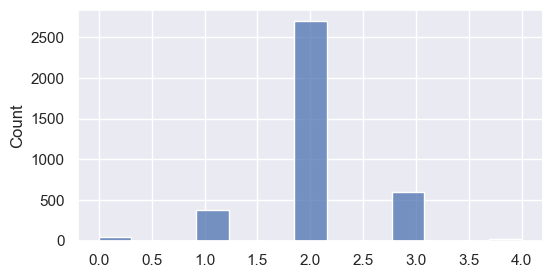

In [66]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_pred)
plt.savefig('BERT_logistic_predictions.png')

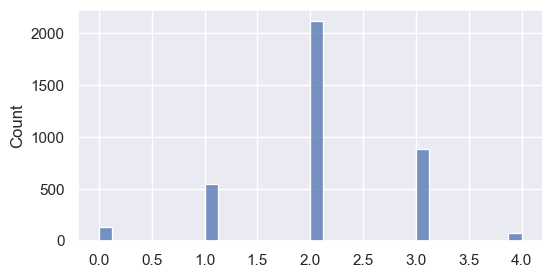

In [67]:
sns.set(rc = {'figure.figsize':(6,3)})
sns.histplot(data=y_test)
plt.savefig('BERT_logistic_ytest.png')

## Random Forest Classifier

In [69]:
%%notify
f_cores = cores-5
fmodel = RandomForestClassifier(n_estimators=500, n_jobs=f_cores, random_state=30)
fmodel.fit(X_train_p, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=16, random_state=30)

<IPython.core.display.Javascript object>

In [70]:
fmodel.score(X_train_p, y_train)

1.0

In [85]:
fmodel.score(X_test_p, y_test)

0.8115825994128636

[8.91363217e-05 1.45929588e-04 7.64672878e-05 ... 1.67123199e-04
 1.34798607e-04 1.11455223e-04]


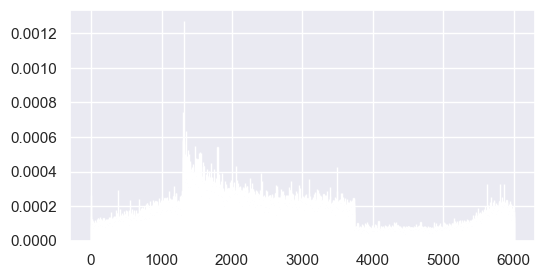

In [84]:
features = fmodel.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

In [92]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(fmodel)
sel.fit(X_train_p, y_train)
mask = sel.get_support()
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [93]:
feature_names = X_train.columns
selected_feature_names = [feature_names[i] for i, selected in enumerate(mask) if selected]
print("Most important features:", selected_feature_names)

Most important features: ['tomatoMeter', 'title_"Sr."', 'title_$9.99', "title_'71", 'title_(500) Days of Summer', 'title_(Untitled)', 'title_... And They Lived Happily Ever After', 'title_...And Justice for All', 'title_10', 'title_10 Cloverfield Lane', 'title_10 Items or Less', 'title_10 on Ten', 'title_100% Wolf', "title_101 Dalmatians II: Patch's London Adventure", 'title_102 Dalmatians', 'title_11-09-01: September 11', 'title_12 Angry Men', 'title_12 Mighty Orphans', 'title_12 Strong', 'title_12 Years a Slave', 'title_127 Hours', 'title_13 Assassins', 'title_13 Going on 30', 'title_13 Hours: The Secret Soldiers of Benghazi', 'title_13 Sins', 'title_14 Blades', 'title_14 Peaks: Nothing Is Impossible', 'title_1408', 'title_15 Minutes', 'title_16 Blocks', 'title_17 Again', 'title_18 1/2', 'title_18 Again!', 'title_1900', 'title_1917', 'title_1945', 'title_1971', 'title_2 Days in New York', 'title_2 Days in the Valley', 'title_2 Fast 2 Furious', 'title_2 Guns', 'title_2001: A Space Ody

In [89]:
X_sc = sc.transform(X)
X_p = pca.transform(X_sc)

In [90]:
%%notify
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X_p), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

<IPython.core.display.Javascript object>

In [91]:
%%notify
clf = LogisticRegression()
clf.fit(X_selected_train_scaled, y_train)
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

Training Score: 0.9531986831568645
Testing Score: 0.7331198291966907


C:\Users\Dan\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<IPython.core.display.Javascript object>

## SVM Classifier (SVC)

In [81]:
%%notify
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    #'epsilon': [0.1, 0.2, 0.5], # For regression models
    'gamma': ['scale', 'auto']  # For RBF kernel
}
svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_p, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_p)

<IPython.core.display.Javascript object>

In [82]:
best_model.score(X_train_p, y_train)

0.9927039772221727

In [83]:
best_model.score(X_test_p, y_test)

0.792100346944222